In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
import cartopy.feature
import cartopy.crs as ccrs
import allel
import os.path as osp

In [2]:
os.environ['USER_PATH']='/home/richras/Ge3Net_Journal/Ge2Net_Repo/'
os.environ['USER_SCRATCH_PATH']="/home/richras/Ge3Net_Journal"
os.environ['OUT_PATH']='/home/richras/Ge3Net_Journal'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
print(torch.__version__)

1.2.0


In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr, convert_nVector
from src.utils.decorators import timer
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss
from src.main.settings_model import parse_args
from src.main.dataset import Haplotype
from src.models.Ge3Net import Ge3NetBase
from src.main.visualization import plot_changepoints
import inference

# load the model and use valid data 

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'], 'data','data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'],'data','data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'],'models','Model_Q_exp_id_3_data_id_4_geo/') 
dataset_type='test'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.test_gens=[0,2,4,8]
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
model_path = osp.join(config['models.dir'], 'models_dir')
modelOption=modelSelect.get_selection()
option = Selections.get_selection()
criterion = option['loss'][params.criteria](reduction='sum', alpha=params.criteria_alpha, geography=params.geography)
cp_criterion=option['cpMetrics']['loss_cp']
params.pretrained=True
params.optimizer='AdamW'
results, test_dataset, model, _=inference.main(config, params)

 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)
INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0722 secs
Finished 'mapping_func' in 0.2716 secs
Finished 'pop_mapping' in 0.0999 secs
Finished 'pop_mapping' in 0.0934 secs
Finished 'transform_data' in 29.5688 secs
Finished '__init__' in 52.9613 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 1.7953 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prM

In [8]:
# Need to read training dataset to mark training locations on the map
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (4778, 317410)
INFO: __init__:src.main.dataset: y_labels data :(4778, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 16
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: __init__:src.main.dataset: y_labels data :(400, 317410)
INFO: __init__:src.main.dataset:Loading gen 24
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: _

Finished '_geoConvertLatLong2nVec' in 0.1849 secs
Finished 'mapping_func' in 0.6697 secs
Finished 'pop_mapping' in 0.2769 secs
Finished 'pop_mapping' in 0.2474 secs
Finished 'transform_data' in 78.4256 secs
Finished '__init__' in 93.1976 secs


In [9]:
model.to(params.device)
next(model.parameters()).is_cuda

True

In [10]:
def getAdmixedSamples(ref_map_path):
    ref_map=pd.read_csv(ref_map_path, sep="\t")
    admixed_ref=ref_map[ref_map.Single_Ancestry==0].reset_index(drop=True)
    return admixed_ref, ref_map

In [11]:
ref_map_path=osp.join(os.environ['OUT_PATH'], 'reference_panel_metadata.tsv')
admixed_ref , full_ref=getAdmixedSamples(ref_map_path)

In [12]:
np.unique(admixed_ref[['Population']].values)

array(['African-American SW', 'African-Caribbean', 'Aleut', 'CEPH',
       'Chukchi', 'Colombian', 'Hawaiian', 'Maori', 'Maya',
       'Mexican-American', 'Mixtec', 'Peruvian', 'Pima', 'Puerto Rican',
       'Tlingit'], dtype=object)

In [13]:
vcf=allel.read_vcf(osp.join(os.environ['OUT_PATH'], 'ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz'))

In [14]:
vcf_npy=vcf2npy(osp.join(os.environ['OUT_PATH'], 'ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz'))

In [15]:
def getAdmixedSnps(sampleID, vcf, vcf_npy):
    idx=np.where(vcf['samples']==sampleID)[0].item()
    admixedSnps_1=vcf_npy[2*idx,:]
    admixedSnps_2=vcf_npy[2*idx+1,:]
    return admixedSnps_1, admixedSnps_2

In [16]:
# idx=0

In [17]:
samples=admixed_ref[admixed_ref.Population=="African-American SW"]['Sample'].values
sampleID = np.random.choice(samples)
# idx+=1
# sampleID=samples[idx]
sampleID='NA20126'
print(sampleID)
samplePopulation=admixed_ref[admixed_ref.Sample==sampleID]['Population'].values[0]
print(samplePopulation)
admixedSnps_1, admixedSnps_2=getAdmixedSnps(sampleID, vcf, vcf_npy)

NA20126
African-American SW


In [118]:
# for any sample
sampleID='HG02278'
print(sampleID)
samplePopulation=full_ref[full_ref.Sample==sampleID]['Population'].values[0]
print(samplePopulation)
admixedSnps_1, admixedSnps_2=getAdmixedSnps(sampleID, vcf, vcf_npy)

HG02278
Peruvian


In [119]:
len(samples)

61

In [120]:
admixedSnps=torch.tensor(admixedSnps_1.reshape(1,-1)).float().to(params.device) #use admixedSnps_2 for African-American sample
admixedSnps.shape

torch.Size([1, 317410])

In [121]:
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():
    test_results=model(admixedSnps[:,:params.chmlen],\
                        mask=torch.ones(1,params.n_win,1).to(params.device))

In [122]:
y_pred = test_results.coord_main.detach().cpu()
n_vec_dim=y_pred.shape[-1]
data_tensor = y_pred
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 0.5028 secs


In [123]:
y_predSample=y_pred.squeeze(0)

In [124]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, params.n_win)
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [125]:
predBOCDSample=model_cpd.cp
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, params.n_win)
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [126]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(params.n_win, i+remWin)
    pred_cps_BOCD[low:high]=1

In [127]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.numpy().reshape(-1,3))

Finished 'nearestNeighbourMapping' in 0.0798 secs


In [128]:
y_True=train_dataset.data['y'].reshape(-1,3)
superpopsTrue=train_dataset.data['superpop'].reshape(-1,)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)

In [129]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [130]:
def formColorMapBySP(superop_dict):
    continentalPops=[superop_dict['EUR'], superop_dict['EAS'], superop_dict['AMR'], superop_dict['SAS'],\
                 superop_dict['AFR'], superop_dict['OCE'], superop_dict['WAS']]
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentalPops, colors_pop)}
    return colors_pop_dict

[(0.9098039215686274, 0.0, 0.043137254901960784), (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), (0.00784313725490196, 0.24313725490196078, 1.0)]


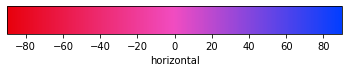

In [131]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

colorsPop_sp_dict = formColorMapBySP(superop_dict)

colorlistH=[colorsPop_sp_dict[superop_dict[k]] for k in ['AMR', 'AFR', 'EUR', 'WAS', 'SAS','EAS', 'OCE' ]]
cmapH = LinearSegmentedColormap.from_list('CmapH', colors=colorlistH, N=317)
# colors_linear_gradient = linear_gradient(colorsPop_sp_dict[superop_dict['AFR']], colorsPop_sp_dict[superop_dict['EUR']], n=317)
colorlistV=[colorsPop_sp_dict[superop_dict['AMR']], colorsPop_sp_dict[superop_dict['AFR']], colorsPop_sp_dict[superop_dict['EUR']]]
print(colorlistV)

cmapV = LinearSegmentedColormap.from_list('CmapV', colors=colorlistV)
# cmapV = LinearSegmentedColormap.from_list('CmapV', colors=colors_linear_gradient)
# norm = plt.Normalize(-90, 90)
# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmapH,orientation='horizontal')
# cb1.set_label('Longitude')
norm=mpl.colors.Normalize(vmin=-90, vmax=90)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapV),
             cax=ax, orientation='horizontal', label='horizontal')
# cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmapV ,orientation='horizontal')
# cb2.set_label('Latitude')
fig.show()

In [132]:
def getCmap(colorsPop_sp_dict, vertical=True):
    if vertical:
        colorlist=[colorsPop_sp_dict[superop_dict['AMR']],colorsPop_sp_dict[superop_dict['AFR']], colorsPop_sp_dict[superop_dict['AFR']], colorsPop_sp_dict[superop_dict['EUR']]]
        norm=mpl.colors.Normalize(vmin=-90, vmax=90)
    else:
        colorlist=[colorsPop_sp_dict[superop_dict[k]] for k in ['OCE', 'AMR', 'AFR', 'EUR', 'WAS', 'SAS','EAS', 'OCE' ]]
        norm=mpl.colors.Normalize(vmin=-180, vmax=180)
    cmap = LinearSegmentedColormap.from_list('Cmap', colors=colorlist, N=317)
    return cmap, norm

In [144]:
@timer
def plot_unlabeledSample(granularPopSample, y_predSample, vertical, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_True=kwargs.get('y_True')
    superpopsTrue=kwargs.get('superpopsTrue')
    superop_dict=kwargs.get('superop_dict')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    set_title=kwargs.get('set_title')
    showCbar=kwargs.get('showCbar')
    showLegend=kwargs.get('showLegend')
    offsets=kwargs.get('offsets')
    
    fig, ax = plt.subplots(figsize=(offsets[4],offsets[5]))
    
    gs1 = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[24,1])
    ax1=fig.add_subplot(gs1[0],projection=ccrs.PlateCarree())
    ax2=fig.add_subplot(gs1[1])
    for axis in [ax, ax2]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['bottom'].set_color('none')
        
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.0)

    ax1.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"), alpha=0.8)
    ax1.add_feature(cartopy.feature.LAND, alpha =0.3)
    ax1.add_feature(cartopy.feature.COASTLINE, alpha =0.5)
    
    # for zoom in
    x_min=np.min(y_predSample[:,1])-offsets[0]
    x_max=np.max(y_predSample[:,1])+offsets[1]
    y_min=np.min(y_predSample[:,0])-offsets[2]
    y_max=np.max(y_predSample[:,0])+offsets[3]
    ax1.set_extent([x_min, x_max, y_min, y_max], ccrs.PlateCarree())
    #ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

    colorsPop_sp_dict = formColorMapBySP(superop_dict)
    cmap, norm = getCmap(colorsPop_sp_dict, vertical=vertical)
    if showLegend:
        patches=[]
        patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=1*'+')) #add UNK legend patch separately
        patches.append(ax1.scatter([],[], color = 'black', marker='x', s=600, linewidths=1, alpha=0.5, label = "Training Locations")) #add training locations
        lgnd = ax1.legend(handles=patches, loc="upper left", fontsize=40)
        ax1.add_artist(lgnd)
    
    # assign color for changepoints
    alpha=[1]*len(y_predSample)
    unknownIdx=np.nonzero(pred_cps)[0]
    print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)*100/len(y_predSample)}")
    granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
    mappedSpArr[unknownIdx]=-1
    colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
    knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]

    #plot the predicted coordinates
    if vertical:
        ax1.scatter(y_predSample[knownIdx,1], y_predSample[knownIdx,0],\
        edgecolor='grey', linewidth=1.5, c = cmap(norm(y_predSample[knownIdx,0])),\
        cmap=cmap, s=600, zorder=0.5)
    else:
        ax1.scatter(y_predSample[knownIdx,1], y_predSample[knownIdx,0],\
        edgecolor='grey', linewidth=1.5, c = cmap(norm(y_predSample[knownIdx,1])),\
        cmap=cmap, s=600, zorder=0.5)
    if cpShow:
        #changepoints
        ax1.scatter(y_predSample[unknownIdx,1], y_predSample[unknownIdx,0], facecolor='grey', hatch=1*'+',\
        color = [tuple(colorsPop_sp_dict[x])+(y,) for x,y in zip(mappedSpArr[unknownIdx], alpha)], s=250, zorder=0, marker="D") 
    
    #training locations
    ax1.scatter(y_True[1].values, y_True[0].values, transform=ccrs.PlateCarree(),\
               color = 'black', marker='x', s=500, linewidths=1, alpha=0.5)
        
    #chm plot of predictions
    for j in unknownIdx:
        bottom=j-1
        ax2.bar( 1, 1.04, color=colorsPop_sp_dict[mappedSpArr[j]], hatch=1*"+", bottom=bottom )
    if vertical:
        for i in knownIdx:
            bottom=i-1
            ax2.bar( 1, 1.04, color=cmap(norm(y_predSample[i,0])), bottom=bottom )
    else:
        for i in knownIdx:
            bottom=i-1
            ax2.bar( 1, 1.04, color=cmap(norm(y_predSample[i,1])), bottom=bottom )
   
    for ax in [ax2]:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.yaxis.set_ticks_position('right')
        ax.tick_params(which='major', width=2, length=10, labelsize=50)
        ax.tick_params(which='minor', width=2, length=6, labelsize=10)
        ax.set_ylim(0, params.n_win)
        ax.set_xlim(0.99,1.09)
        positions = [5, int(params.n_win/2), params.n_win-4]
        y_labels = [0, int(params.n_win*1000/2), params.n_win*1000]
        ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_labels))
        ax.axes.get_xaxis().set_visible(False)

    if set_title is not None:
        ax1.set_title(granularPopSample[0], fontsize=50, loc='left')
    plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=0.4)
    if showCbar:
        cbaxes = inset_axes(ax1, width="3%", height="30%", loc=3, bbox_to_anchor=(0.03, 0.3, 1, 1),\
                              bbox_transform=ax1.transAxes, borderpad=0) 
        cbaxes.tick_params(labelsize=25)
        if vertical:
            orientation='vertical' 
            ticks= [-90,0,90]
        else:
            orientation='horizontal'
            ticks= [-180,0,180]
           
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=ticks,cax=cbaxes, orientation=orientation)
    plt.show()
    plt.close('all')

In [145]:
granularPopSample=['_'.join([str(sampleID), str(samplePopulation)])]*params.n_win
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
unique_coord = train_dataset.data['y']
labels_all=load_path(osp.join(labels_path, 'labels.pkl'), en_pickle=True)
train_sample_map=pd.read_csv(osp.join(labels_path, 'train_sample_map.tsv'), sep="\t")
pop_arr_train = repeat_pop_arr(train_sample_map)
n_dim=2
labelsTrainArr=np.zeros((len(pop_arr_train), n_dim))
for i,j in enumerate(pop_arr_train[:,1]):
    labelsTrainArr[i,:]=labels_all.get(j) #5930x3 #samplesxdim
df_trainLabels=pd.DataFrame(labelsTrainArr)
df_trainLabels=df_trainLabels.drop_duplicates().reset_index(drop=True)

In [148]:
df_trainLabels

,0,1
0,54.003660,-2.547855
1,64.498846,26.274666
2,25.900000,118.300000
3,22.000302,100.798370
4,40.244487,-3.647550
...,...,...
138,69.900000,27.000000
139,32.200000,35.300000
140,37.498611,71.544798
141,38.700000,35.500000


number of changepoints removed:0,0.0


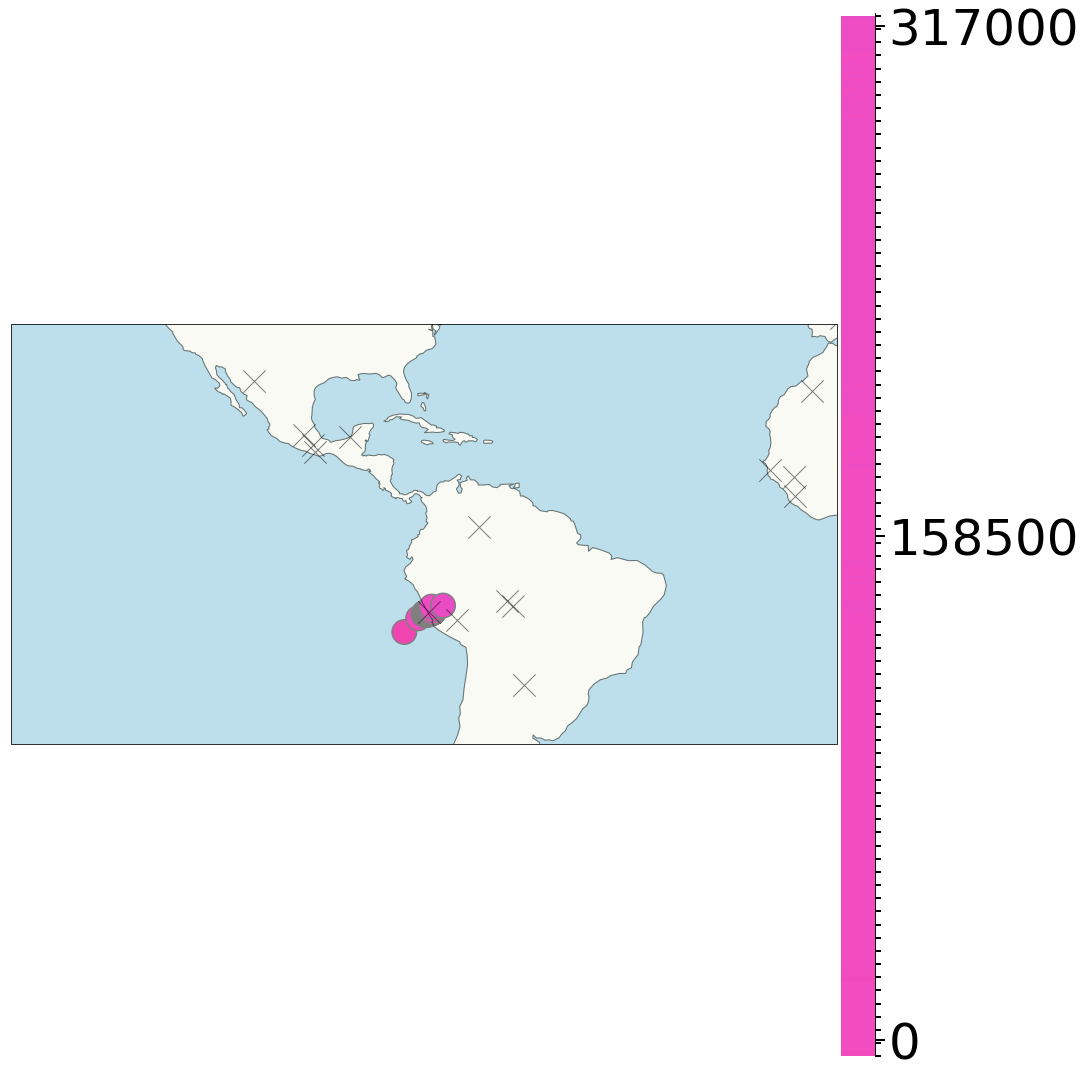

Finished 'plot_unlabeledSample' in 1.0521 secs


In [150]:
# offsets=[15,5,5,15,17,18] #African-American sample
# offsets=[15,5,5,15,17,18] #mozabite/Algeria sample 
# offsets=[30,20,20,15,17,18] #Kailash sample 
offsets=[70,70,20,50,15,15] #Peruvian sample 
plot_unlabeledSample(granularPopSample, pred_coord, vertical=False, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_True=df_trainLabels, superpopsTrue=superpopsTrue, superop_dict=superop_dict, \
cpShow=False, showCbar=False, showLegend=False, offsets=offsets)

In [122]:
def plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, **kwargs):
    """
    plotly plot for coordinates on a map
    label: target label vector (int) for the specific sample
    data_coordinates: lat, long for the specific sample
    rev_pop_order: dict with keys as target label ints and values
    as granular population name
    """
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    alpha=[1.0]*len(lbl_coord)
    if cpShow:
        unknownIdx=np.nonzero(pred_cps)[0]
        granularPopNames=["UNK" if i in unknownIdx else granularPopNames[i] for i in range(len(granularPopNames))]
    fig = go.Figure(go.Scattergeo())
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopNames)))
    
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopNames), colors_pop)}
    colors_pop_dict['UNK']=(188,188,188) # grey color
    fig.add_trace(go.Scattergeo(lon=pred_coord[:,1], lat=pred_coord[:,0], text = granularPopNames,\
    marker_color=['rgba'+str(colors_pop_dict[x]+(y,)) for x,y in zip(granularPopNames, alpha)]))
    fig.update_traces(marker_size = 5)
    fig.add_trace(go.Scattergeo(lon=lbl_coord[:,1], lat=lbl_coord[:,0], marker = dict(symbol = 'square'), \
                                text = granularPopNames))
    fig.update_traces(marker_size = 5)

    fig.show()
    plt.show()
    plt.close('all')